<a href="https://colab.research.google.com/github/ajit-ai/DataScience/blob/main/Tensorflow_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

In [2]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.01
training_steps = 20000
batch_size = 256
display_step = 1000

# Network Parameters
num_hidden_1 = 128 # 1st layer num features.
num_hidden_2 = 64 # 2nd layer num features (the latent dim).

In [3]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [5]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    'encoder_h1': tf.Variable(random_normal([num_features, num_hidden_1])),
    'encoder_h2': tf.Variable(random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(random_normal([num_hidden_1, num_features])),
}
biases = {
    'encoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(random_normal([num_features])),
}

In [6]:
# Building the encoder.
def encoder(x):
    # Encoder Hidden layer with sigmoid activation.
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation.
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder.
def decoder(x):
    # Decoder Hidden layer with sigmoid activation.
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation.
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

In [7]:
# Mean square loss between original images and reconstructed ones.
def mean_square(reconstructed, original):
    return tf.reduce_mean(tf.pow(original - reconstructed, 2))

# Adam optimizer.
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [10]:
# Optimization process.
def run_optimization(x):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        reconstructed_image = decoder(encoder(x))
        loss = mean_square(reconstructed_image, x)

    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [11]:
# Run training for the given number of steps.
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):

    # Run the optimization.
    loss = run_optimization(batch_x)

    if step % display_step == 0:
        print("step: %i, loss: %f" % (step, loss))

step: 0, loss: 0.235772
step: 1000, loss: 0.017546
step: 2000, loss: 0.011344
step: 3000, loss: 0.008689
step: 4000, loss: 0.007172
step: 5000, loss: 0.007109
step: 6000, loss: 0.006058
step: 7000, loss: 0.005822
step: 8000, loss: 0.005445
step: 9000, loss: 0.005050
step: 10000, loss: 0.004892
step: 11000, loss: 0.005021
step: 12000, loss: 0.004630
step: 13000, loss: 0.004799
step: 14000, loss: 0.004504
step: 15000, loss: 0.004056
step: 16000, loss: 0.004331
step: 17000, loss: 0.004025
step: 18000, loss: 0.003930
step: 19000, loss: 0.003999
step: 20000, loss: 0.003485


In [13]:
# Testing and Visualization.
import matplotlib.pyplot as plt

Original Images


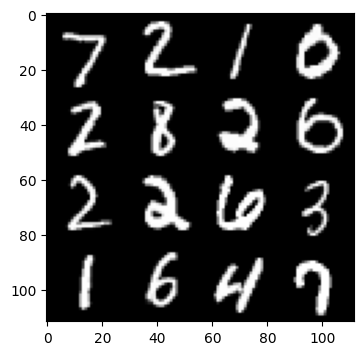

Reconstructed Images


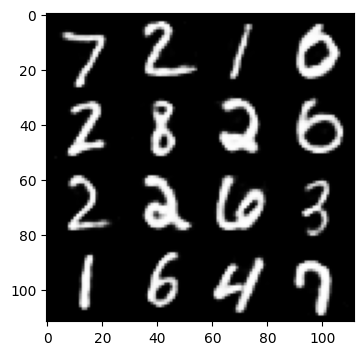

In [14]:
# Encode and decode images from test set and visualize their reconstruction.
n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i, (batch_x, _) in enumerate(test_data.take(n)):
    # Encode and decode the digit image.
    reconstructed_images = decoder(encoder(batch_x))
    # Display original images.
    for j in range(n):
        # Draw the generated digits.
        img = batch_x[j].numpy().reshape([28, 28])
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
    # Display reconstructed images.
    for j in range(n):
        # Draw the generated digits.
        reconstr_img = reconstructed_images[j].numpy().reshape([28, 28])
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = reconstr_img

print("Original Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

In [15]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow v2.
import tensorflow as tf

from tensorflow.keras import Model, layers
import numpy as np

In [16]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Training Parameters
learning_rate = 0.001
training_steps = 1000
batch_size = 32
display_step = 100

# Network Parameters
# MNIST image shape is 28*28px, we will then handle 28 sequences of 28 timesteps for every sample.
num_input = 28 # number of sequences.
timesteps = 28 # timesteps.
num_units = 32 # number of neurons for the LSTM layer.

In [18]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
# The code snippet `# Prepare MNIST data.` is preparing the MNIST dataset for training a machine learning model. It includes loading the dataset, converting the data to float32 data type, flattening the images to a 1-D vector of 784 features, and normalizing the pixel values from the range [0, 255] to [0, 1].
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, 28, 28]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [19]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [20]:
# Create LSTM Model.
class BiRNN(Model):
    # Set layers.
    def __init__(self):
        super(BiRNN, self).__init__()
        # Define 2 LSTM layers for forward and backward sequences.
        lstm_fw = layers.LSTM(units=num_units)
        lstm_bw = layers.LSTM(units=num_units, go_backwards=True)
        # BiRNN layer.
        self.bi_lstm = layers.Bidirectional(lstm_fw, backward_layer=lstm_bw)
        # Output layer (num_classes).
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.bi_lstm(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build LSTM model.
birnn_net = BiRNN()

In [21]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Adam optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [22]:
# Optimization process.
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = birnn_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)

    # Variables to update, i.e. trainable variables.
    trainable_variables = birnn_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [23]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)

    if step % display_step == 0:
        pred = birnn_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 1.707473, accuracy: 0.406250
step: 200, loss: 1.008171, accuracy: 0.718750
step: 300, loss: 0.538891, accuracy: 0.843750
step: 400, loss: 0.500442, accuracy: 0.875000
step: 500, loss: 0.911719, accuracy: 0.750000
step: 600, loss: 0.356662, accuracy: 0.906250
step: 700, loss: 0.412855, accuracy: 0.875000
step: 800, loss: 0.170980, accuracy: 0.968750
step: 900, loss: 0.422504, accuracy: 0.906250
step: 1000, loss: 0.358354, accuracy: 0.875000


In [24]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

In [25]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).

# Training parameters.
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

# Network parameters.
conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 1024 # number of neurons for 1st fully-connected layer.

In [26]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [27]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [28]:
# Create some wrappers for simplicity.
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation.
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper.
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [29]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    # Conv Layer 1: 5x5 conv, 1 input, 32 filters (MNIST has 1 color channel only).
    'wc1': tf.Variable(random_normal([5, 5, 1, conv1_filters])),
    # Conv Layer 2: 5x5 conv, 32 inputs, 64 filters.
    'wc2': tf.Variable(random_normal([5, 5, conv1_filters, conv2_filters])),
    # FC Layer 1: 7*7*64 inputs, 1024 units.
    'wd1': tf.Variable(random_normal([7*7*64, fc1_units])),
    # FC Out Layer: 1024 inputs, 10 units (total number of classes)
    'out': tf.Variable(random_normal([fc1_units, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [30]:
# Create model
def conv_net(x):

    # Input shape: [-1, 28, 28, 1]. A batch of 28x28x1 (grayscale) images.
    x = tf.reshape(x, [-1, 28, 28, 1])

    # Convolution Layer. Output shape: [-1, 28, 28, 32].
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])

    # Max Pooling (down-sampling). Output shape: [-1, 14, 14, 32].
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer. Output shape: [-1, 14, 14, 64].
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])

    # Max Pooling (down-sampling). Output shape: [-1, 7, 7, 64].
    conv2 = maxpool2d(conv2, k=2)

    # Reshape conv2 output to fit fully connected layer input, Output shape: [-1, 7*7*64].
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])

    # Fully connected layer, Output shape: [-1, 1024].
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    # Apply ReLU to fc1 output for non-linearity.
    fc1 = tf.nn.relu(fc1)

    # Fully connected layer, Output shape: [-1, 10].
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out)

In [31]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# ADAM optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [32]:
# Optimization process.
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = conv_net(x)
        loss = cross_entropy(pred, y)

    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [33]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)

    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 89.833252, accuracy: 0.804688
step: 20, loss: 38.915459, accuracy: 0.906250
step: 30, loss: 33.949879, accuracy: 0.937500
step: 40, loss: 31.886177, accuracy: 0.929688
step: 50, loss: 13.680361, accuracy: 0.968750
step: 60, loss: 20.131187, accuracy: 0.953125
step: 70, loss: 12.533766, accuracy: 0.976562
step: 80, loss: 9.084615, accuracy: 0.992188
step: 90, loss: 12.177880, accuracy: 0.976562
step: 100, loss: 11.339981, accuracy: 0.984375
step: 110, loss: 14.697313, accuracy: 0.960938
step: 120, loss: 5.636759, accuracy: 0.992188
step: 130, loss: 7.196815, accuracy: 0.992188
step: 140, loss: 12.811012, accuracy: 0.976562
step: 150, loss: 7.508259, accuracy: 0.984375
step: 160, loss: 6.150401, accuracy: 0.984375
step: 170, loss: 8.060769, accuracy: 0.992188
step: 180, loss: 7.874563, accuracy: 0.976562
step: 190, loss: 11.870804, accuracy: 0.960938
step: 200, loss: 6.366780, accuracy: 0.992188


In [34]:
# Test model on validation set.
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.980400


In [35]:
# Visualize predictions.
import matplotlib.pyplot as plt

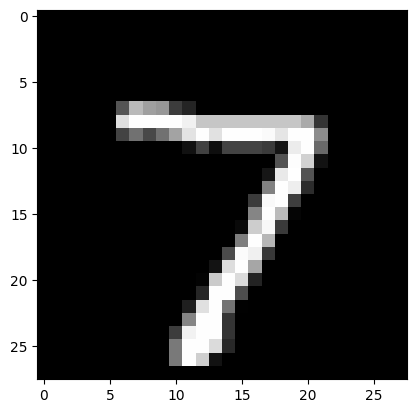

Model prediction: 7


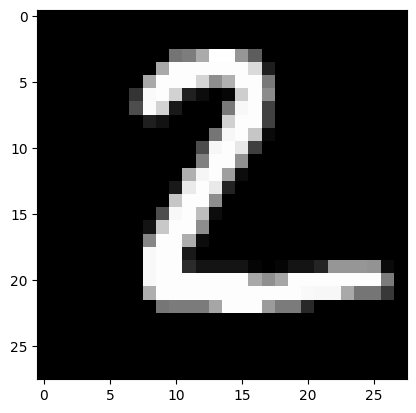

Model prediction: 2


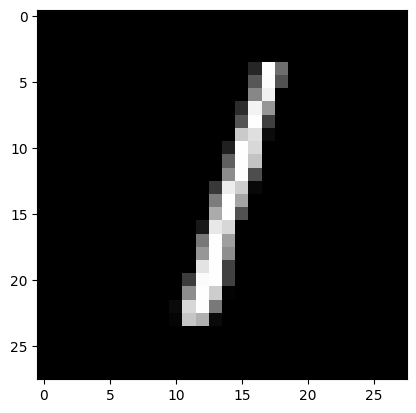

Model prediction: 1


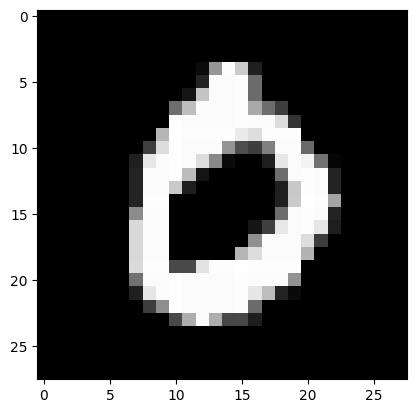

Model prediction: 0


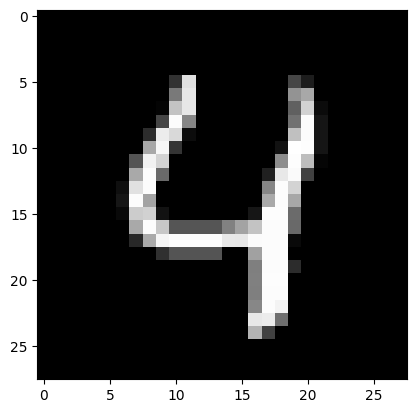

Model prediction: 4


In [36]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = conv_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))